In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('display.max_columns', 100)
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
df=pd.read_csv('recom.csv')

In [3]:
df.head()

,Unnamed: 0,Main_ID,Transaction_ID,Date,Price,Code_Product,Amount,ItemKey
0,0,90fada91,264f7a69,2022-10-07 20:53:49.153,125.0,5002.0,1.0,5002.0
1,1,9006f9ac,45c7d853,2022-09-17 15:54:57.187,19.0,35012.0,1.0,NaN
2,2,32270891,61ad76dd,2022-11-28 13:51:55.667,141.0,5005.0,1.0,5005.0
3,3,97e03e47,41ee09f6,2022-09-12 16:20:22.110,4.5,35078.5,1.0,NaN
4,4,41949228,244fe6d8,2022-10-14 18:53:43.933,129.5,49291.5,5.0,NaN


In [4]:
df = pd.read_csv('recom.csv', usecols=lambda column: column not in ['Unnamed: 0', 'ItemKey'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Main_ID         50000 non-null  object 
 1   Transaction_ID  50000 non-null  object 
 2   Date            50000 non-null  object 
 3   Price           50000 non-null  float64
 4   Code_Product    50000 non-null  float64
 5   Amount          50000 non-null  float64
dtypes: float64(3), object(3)
memory usage: 2.3+ MB


In [6]:
#Toplam harcamayi Column olarak ekliyoruz
df['TotalPrice']=df['Amount']*df['Price']

In [7]:
#siparis tarihinin veri tipini degistiriyoruz
df['Date']=pd.to_datetime(df['Date'])

In [8]:
# bugunu/ analiz tarihini degisken olarak atiyoruz.
today= dt.datetime(2023,1,1)
print(today)

2023-01-01 00:00:00


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,50000.0,62.56067,68.269624,0.5,24.5,45.5,83.0,2525.5
Code_Product,50000.0,32379.29354,21697.500334,5000.5,10013.0,40009.5,49291.5,350027.5
Amount,50000.0,1.23264,0.749353,1.0,1.0,1.0,1.0,54.0
TotalPrice,50000.0,89.22196,371.822461,0.5,25.5,48.0,95.5,37026.0


In [10]:
# minimumu 0 olan deger yok.. silmeye gerek yok!

In [11]:
# Recency ve Monetary degerlerini bulalim
df_x=df.groupby('Main_ID').agg({'TotalPrice': lambda x: x.sum(),'Date':lambda x: (today-x.max()).days})

In [12]:
#Transaction_ID code halinde oldugu icin Transaction_ID'yi (Invoice) unique hale getiriyoruz.
df_y=df.groupby(['Main_ID','Transaction_ID']).agg({'TotalPrice': lambda x: x.sum()})

In [13]:
# saydirdigimizda Transaction_ID unique halde gelmis oluyor.
df_z=df.groupby('Main_ID').agg({'TotalPrice': lambda x: len(x)})

In [14]:
#RFM tablosuna ulasmis oluyoruz
rfm_table = pd.merge(df_x, df_z, on='Main_ID')


In [15]:
#column isimlerini belirliyoruz
rfm_table.rename(columns={'Date': 'Recency',
                          'TotalPrice_x':'Monetary',
                          'TotalPrice_y':'Frequency'},inplace=True)

In [16]:
rfm_table.head()

,Monetary,Recency,Frequency
Main_ID,,,
00024de6,12.0,119,1.0
00084856,46.0,56,2.0
0008e848,13.0,109,1.0
00096930,96.0,36,1.0
000c66b7,62.0,116,2.0


In [17]:
#Frequency bulma
def FScore(x,p,d):
    if x<=d[p][0.20]:
        return 0
    elif x<=d[p][0.40]:
        return 1
    elif x<=d[p][0.60]:
        return 2
    elif x<=d[p][0.80]:
        return 3
    else:
        return 4
    
    
quantiles= rfm_table.quantile(q=[0.20, 0.40, 0.60, 0.80])
quantiles=quantiles.to_dict()
rfm_table['Freq_Tile']=rfm_table['Frequency'].apply(FScore, args=('Frequency',quantiles))
#Recency bulma
rfm_table= rfm_table.sort_values('Recency', ascending=True)
rfm_table['Rec_Tile']=pd.qcut(rfm_table['Recency'],5,labels=False)

#Monetary bulma
# rfm_table= rfm_table.sort_values('Monetary', ascending=True)
rfm_table['Mone_Tile']=pd.qcut(rfm_table['Monetary'],5,labels=False)

# '0' degeri yer almasin istiyorsak, buldugumuz degerleri 1 artiririz
rfm_table['Rec_Tile']=rfm_table['Rec_Tile'] +1
rfm_table['Freq_Tile']=rfm_table['Freq_Tile']+1
rfm_table['Mone_Tile']=rfm_table['Mone_Tile']+1

#buldugumuz degerleri birlestirip tek 1 skor elde ediyoruz.
rfm_table['RFM Score']=rfm_table['Rec_Tile'].map(str)+rfm_table['Freq_Tile'].map(str)+rfm_table['Mone_Tile'].map(str)

rfm_table.head()



    

,Monetary,Recency,Frequency,Freq_Tile,Rec_Tile,Mone_Tile,RFM Score
Main_ID,,,,,,,
6558ca78,208.5,28,8.0,5,1,5,155
80851dc3,24.5,28,1.0,1,1,1,111
387aecb7,83.5,28,1.0,1,1,4,114
a70f5f11,412.0,28,4.0,5,1,5,155
27aa514e,2426.5,28,12.0,5,1,5,155


In [22]:
#degerlerin iceriklerini inceliyoruz
rfm_table.groupby('RFM Score').agg({
    'Recency': ['mean','min','max','count'],
    'Frequency':['mean','min','max','count'],
    'Monetary':['mean','min','max','count'] }).round(1).head()


Recency               Frequency                 Monetary         \
             mean min max count      mean  min  max count     mean    min   
RFM Score                                                                   
111          34.0  28  40   942       1.0  1.0  1.0   942     14.7    0.5   
112          34.3  29  40   824       1.0  1.0  1.0   824     32.6   25.0   
113          34.3  29  40   682       1.0  1.0  1.0   682     52.6   41.5   
114          34.2  28  40   582       1.0  1.0  1.0   582     92.5   69.5   
115          33.9  29  40   250       1.0  1.0  1.0   250    244.8  131.0   

                         
              max count  
RFM Score                
111          24.5   942  
112          41.0   824  
113          68.5   682  
114         130.5   582  
115        1494.5   250

In [24]:
rfm_table.groupby('RFM Score').size().sort_values(ascending=False)[:20]

RFM Score
511    1380
155    1346
412    1200
311    1188
411    1155
512    1150
513    1117
312    1084
212    1071
413    1070
313     985
514     947
111     942
213     899
414     858
211     857
112     824
214     806
314     801
255     752
dtype: int64

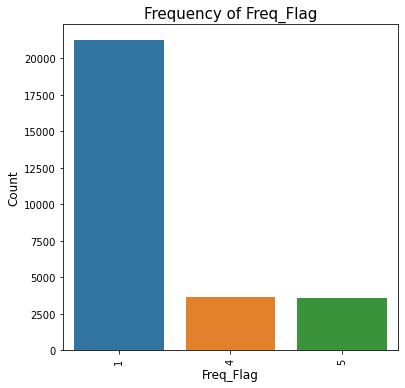

In [29]:
plt.figure(figsize=(6,6))
sns.countplot(x='Freq_Tile', data=rfm_table)
plt.ylabel('Count',fontsize=12)
plt.xlabel('Freq_Flag',fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequency of Freq_Flag', fontsize=15)
plt.show()





C:\Users\33758\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


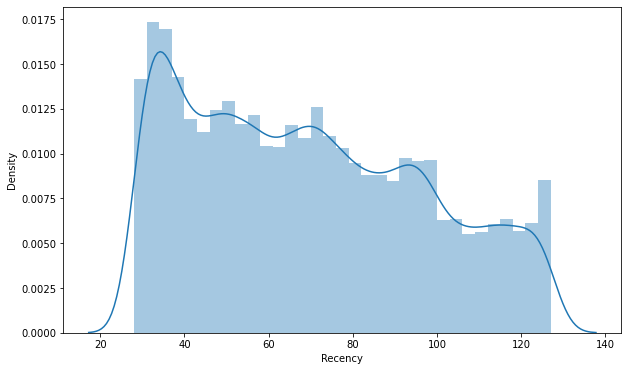

In [32]:
sns.distplot(rfm_table['Recency'])
plt.show()   

  


C:\Users\33758\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


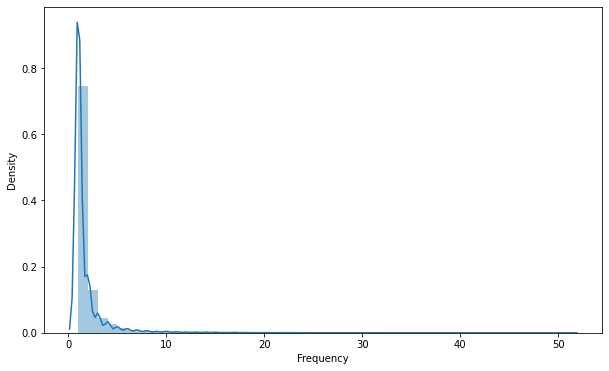

In [33]:
sns.distplot(rfm_table['Frequency'])
plt.show()   


C:\Users\33758\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


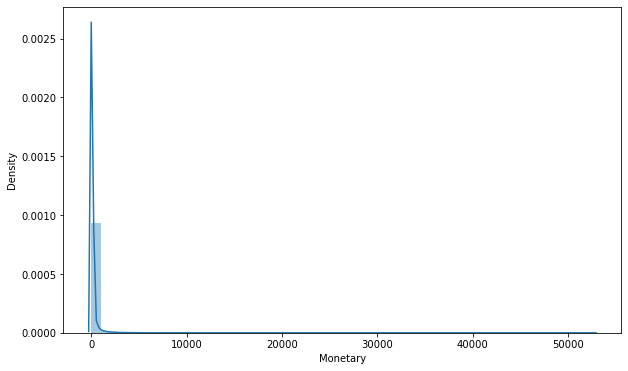

In [34]:
sns.distplot(rfm_table['Monetary'])
plt.show()   


In [35]:
rfm_table.head()

,Monetary,Recency,Frequency,Freq_Tile,Rec_Tile,Mone_Tile,RFM Score
Main_ID,,,,,,,
6558ca78,208.5,28,8.0,5,1,5,155
80851dc3,24.5,28,1.0,1,1,1,111
387aecb7,83.5,28,1.0,1,1,4,114
a70f5f11,412.0,28,4.0,5,1,5,155
27aa514e,2426.5,28,12.0,5,1,5,155


In [36]:
clus= rfm_table[['Monetary','Recency','Frequency']]

In [37]:
clus.head()

,Monetary,Recency,Frequency
Main_ID,,,
6558ca78,208.5,28,8.0
80851dc3,24.5,28,1.0
387aecb7,83.5,28,1.0
a70f5f11,412.0,28,4.0
27aa514e,2426.5,28,12.0


In [38]:
clusterdata=clus.iloc[:,0:4]
clusterdata.head()

,Monetary,Recency,Frequency
Main_ID,,,
6558ca78,208.5,28,8.0
80851dc3,24.5,28,1.0
387aecb7,83.5,28,1.0
a70f5f11,412.0,28,4.0
27aa514e,2426.5,28,12.0


In [44]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler= MinMaxScaler()
x_scaled=min_max_scaler.fit_transform(clus)
data_scaled2= pd.DataFrame(x_scaled)
# Virgülden sonra 4 basamak gösterme ayarı
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))

In [45]:
data_scaled2.head()

,0,1,2
0,0.0040,0.0000,0.1400
1,0.0005,0.0000,0.0000
2,0.0016,0.0000,0.0000
3,0.0078,0.0000,0.0600
4,0.0461,0.0000,0.2200


In [46]:
# Virgülden sonra 2 basamak gösterme ayarı
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

In [47]:
data_scaled2.head()

,0,1,2
0,0.00,0.00,0.14
1,0.00,0.00,0.00
2,0.00,0.00,0.00
3,0.01,0.00,0.06
4,0.05,0.00,0.22


In [50]:
data_scaled2.describe().T

,count,mean,std,min,25%,50%,75%,max
0,28514.00000000,0.00296297,0.01407280,0.00000000,0.00054148,0.00099745,0.00200441,1.00000000
1,28514.00000000,0.41571923,0.28164420,0.00000000,0.17171717,0.38383838,0.63636364,1.00000000
2,28514.00000000,0.01507049,0.04613004,0.00000000,0.00000000,0.00000000,0.02000000,1.00000000


In [51]:
?KMeans

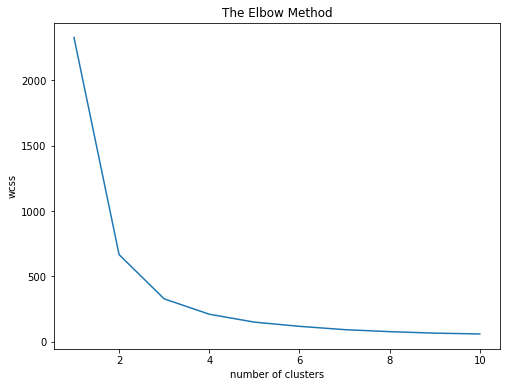

In [53]:
plt.figure(figsize=(8,6))
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i, init='k-means++',n_init=10, max_iter=300)
    kmeans.fit(data_scaled2)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method')
plt.xlabel('number of clusters')
plt.ylabel('wcss')
plt.show()


In [55]:
from sklearn.metrics import silhouette_score
inertia_list=[]
silhouette_score_list=[]
for i in range (2,10):
    #kmeans=KMeans(n_clusters=i, init='k-means++',n_init=10, max_iter=300)
    kmeans.fit(data_scaled2)
    silhouette_score_list.append(silhouette_score(data_scaled2,kmeans.labels_))
    print(silhouette_score_list)
    




[0.467980804327786]
[0.467980804327786, 0.47567341430395754]
[0.467980804327786, 0.47567341430395754, 0.4715499574535429]
[0.467980804327786, 0.47567341430395754, 0.4715499574535429, 0.47471946141543103]
[0.467980804327786, 0.47567341430395754, 0.4715499574535429, 0.47471946141543103, 0.47033929713185396]
[0.467980804327786, 0.47567341430395754, 0.4715499574535429, 0.47471946141543103, 0.47033929713185396, 0.4722363091279877]
[0.467980804327786, 0.47567341430395754, 0.4715499574535429, 0.47471946141543103, 0.47033929713185396, 0.4722363091279877, 0.4729270934036431]
[0.467980804327786, 0.47567341430395754, 0.4715499574535429, 0.47471946141543103, 0.47033929713185396, 0.4722363091279877, 0.4729270934036431, 0.4835811718922774]


In [56]:
#kmeans using 4 clusters and k-means++ initialization
kmeans= KMeans(n_clusters=i, init='k-means++',n_init=10, max_iter=300)
kmeans.fit(data_scaled2)
pred=kmeans.predict(data_scaled2)

In [59]:
d_frame=pd.DataFrame(clus)
d_frame['cluster']=pred
d_frame['cluster'].value_counts()

4    4958
0    4209
1    4020
5    3805
3    3497
7    3173
2    2196
8    2104
6     552
Name: cluster, dtype: int64

In [60]:
d_frame.head()

,Monetary,Recency,Frequency,cluster
Main_ID,,,,
6558ca78,208.50000000,28,8.00000000,4
80851dc3,24.50000000,28,1.00000000,4
387aecb7,83.50000000,28,1.00000000,4
a70f5f11,412.00000000,28,4.00000000,4
27aa514e,2426.50000000,28,12.00000000,6


In [62]:
d_frame.groupby('cluster').mean()

,Monetary,Recency,Frequency
cluster,,,
0,105.91981468,69.91161796,1.41268710
1,130.62300995,45.71169154,1.67412935
2,104.32786885,109.04280510,1.21083789
3,88.49399485,95.13525879,1.21904490
4,156.75534490,33.67002824,1.96208148
5,126.58948752,57.33823916,1.59868594
6,2228.31793478,35.59601449,14.44384058
7,90.77355815,82.29561929,1.34005673
8,83.02637833,121.61311787,1.12452471


In [ ]:
#1 cluster 6 en cok siklikla ve cok harcama yapmis, VIP musterimiz diyebiliriz.. bircok pazarlama calismasi yapilabilir!
#2 cluster 8 en az siklikla ve en az harcama ortalamasina sahip,
## Recency degeri GUN sayisini belirtir. Verinin tarih araligina bakilirsa cluster 8 1 defa alisveris yapmis gibi.

## Association Rules - Birliktelik Analizi

In [71]:
!pip install mlxtend --user

In [72]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

ModuleNotFoundError: No module named 'mlxtend'